In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../../module/')

import keras2
from keras2.models import Model
from keras2.layers import concatenate, Dense, Input, Flatten
from keras2.optimizers import Adam
from util import moving_average, dlqr, discretized_system, lqr
import gym2
from rl2.agents import selfDDPGAgent
from rl2.memory import SequentialMemory

Using TensorFlow backend.
Using TensorFlow backend.


In [2]:
# GymのPendulum環境を作成
env = gym2.make("Pendulum-v2")
clip = 10.

# 取りうる”打ち手”のアクション数と値の定義
nb_actios = 2
ACT_ID_TO_VALUE = {0: [-1], 1: [+1]}

In [3]:
def actor_net(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input)
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(2, activation="self_trigger_output")(x)
    actor = Model(inputs=action_input, outputs=x)
    # actor.summary()
    # actor.set_weights(_actor_initial_weight(actor))
    return actor

def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

def agent(a_shape, s_shape):
    actor = actor_net(a_shape, s_shape)
    critic,  critic_action_input = critic_net(a_shape, s_shape)
    memory = SequentialMemory(limit = 50000, window_length = 1)
    agent = selfDDPGAgent(
        a_shape[0],
        actor,
        critic,
        critic_action_input,
        memory,
        clip_com = 0.01
    )
    return agent

In [9]:
#safe learning
l = 50.
step = 200000  # num of interval
episode_step = step
a = agent((2,), (2,))
a.compile(Adam(lr=0.001, clipnorm=1.), metrics=["mae"])
a.actor.load_weights('./saved_agent/self_trigger.h5')
# a.load_weights('../learned_models_vol2/0.5standup-agent.h5')
# a.load_weights('../../learned_models_stab/lqr_optimal_agent.h5')
out = a.fit(env, l=l, nb_steps=step, visualize=0, verbose=1, nb_max_episode_steps=episode_step)

Training for 200000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 69s 7ms/step - reward: 3.1523
79 episodes - episode_reward: 396.302 [-1036.880, 493.226] - loss: 1.816 - mean_absolute_error: 0.749 - mean_q: 8.442

Interval 2 (10000 steps performed)
  376/10000 [>.............................] - ETA: 1:12 - reward: 4.8725done, took 71.448 seconds


In [10]:
states = []
taus = []
for _ in range(10000):
    x = np.random.randn(2)
    states.append(x)
    taus.append(a.forward(x)[1])
states = np.array(states)

<IPython.core.display.Javascript object>


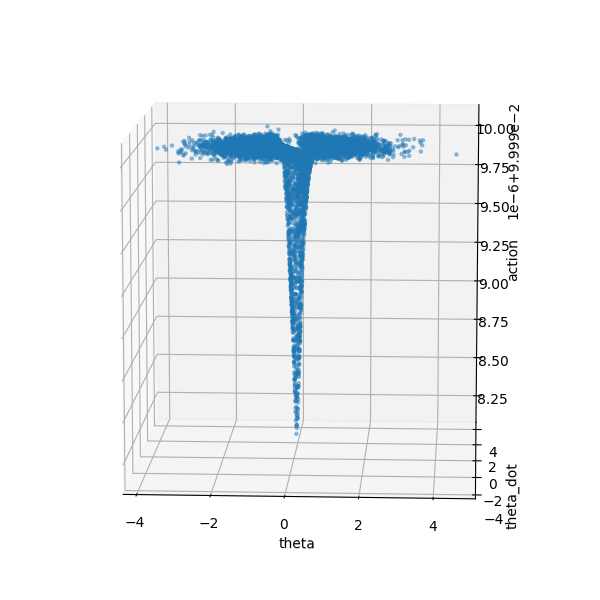

In [11]:
%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.set_xlabel('theta')
ax.set_ylabel('theta_dot')
ax.set_zlabel('action')

ax.scatter3D(states[:,0], states[:,1], taus, marker='.', alpha=0.4)

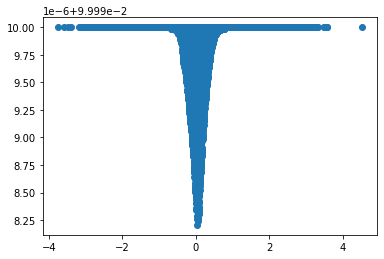

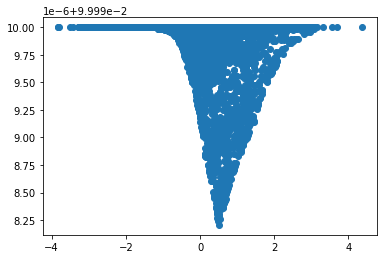

In [12]:
%matplotlib inline
plt.scatter(states[:,0], taus)
plt.show()
plt.scatter(states[:,1], taus)
plt.show()

In [13]:
print(taus)

[0.09999998, 0.1, 0.1, 0.1, 0.1, 0.09999998, 0.1, 0.1, 0.1, 0.1, 0.1, 0.09999998, 0.09999967, 0.1, 0.09999999, 0.1, 0.1, 0.1, 0.09999841, 0.1, 0.1, 0.09999998, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.09999948, 0.09999893, 0.1, 0.1, 0.09999966, 0.1, 0.1, 0.1, 0.1, 0.09999999, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.09999927, 0.09999984, 0.1, 0.09999907, 0.1, 0.09999999, 0.099999964, 0.1, 0.09999917, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.09999999, 0.1, 0.0999998, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0999996, 0.1, 0.09999952, 0.099999756, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.099999905, 0.1, 0.09999998, 0.1, 0.099999614, 0.1, 0.1, 0.1, 0.1, 0.1, 0.09999999, 0.1, 0.1, 0.099999964, 0.1, 0.09999933, 0.1, 0.1, 0.09999895, 0.1, 0.09999966, 0.1, 0.1, 0.1, 0.09999978, 0.1, 0.09999901, 0.1, 0.1, 0.1, 0.09999996, 0.1, 0.1, 0.1, 0.1, 0.09999998, 0.1, 0.1, 0.0999999, 0.1, 0.09999974, 0.09999994, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.09999996, 0.1, 0.1, 0.09999893, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,

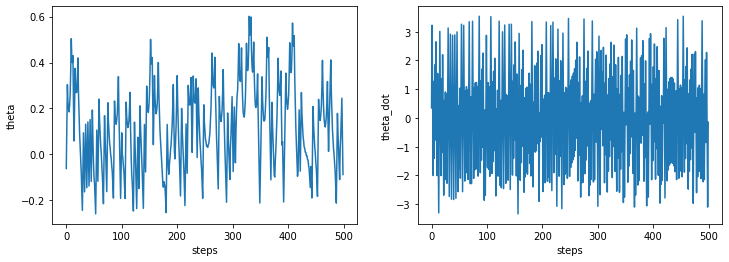

In [14]:
def rad_clip(th):
    r = abs(th)
    while r > np.pi:
        r -= np.pi
    th = np.sign(th) * r
    return th

env.reset()
states = []
reward = 0
for i in range(500):
    x = env.state
    states.append([rad_clip(x[0]), x[1]])
    a_agent, tau = a.forward(x)
    action_repetition = int(np.ceil(200 * tau))  # minimum natural number which makes `dt` smaller than 0.005
    dt = tau / action_repetition
    # print(tau, dt, action_repetition)
    for p in range(action_repetition):
        _,_,r,_ = env.step(np.array([a_agent]), dt, tau)
        reward += r
    reward += - 0.01 * a_agent**2 + l * tau
states = np.array(states)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.xlabel('steps')
plt.ylabel('theta')
plt.plot(range(states.shape[0]), states[:,0])
plt.subplot(1,2,2)
plt.xlabel('steps')
plt.ylabel('theta_dot')
plt.plot(range(states.shape[0]), states[:,1])
plt.show()